In [186]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [187]:
stocks = ["AAPL", "SPY"]

In [269]:
class Backtest:
    def __init__(self, stocks, start_date, end_date, interval="1d"):
        self.stocks = stocks
        self.s_d = start_date
        self.e_d = end_date
        self.interval = interval
        self.data = pd.DataFrame()
        self.strategies = {}
    def init(self):
        for stock in stocks:
            self.data = pd.concat([self.data, yf.download(tickers=stock, start=self.s_d, end=self.e_d, interval=self.interval)], axis=1)

    def plot(self, cols=["Open"]):
        plt.figure(figsize=(12, 6))
        for col in cols:
            plt.plot(self.data[col], label=self.stocks)
        plt.legend()
        plt.show()

    def add_strategy(self, strat):
        self.strategies[strat.name] = strat
        self.data[(strat.name, "Balance")] = strat.balance

    def plot_equity_curve(self):
        plt.figure(figsize=(12, 6))
        for strat in self.strategies:
            plt.plot(self.data[(strat, "Balance")], label=strat)
        plt.legend()
        plt.show()

    def run(self):
        for strat in self.strategies:
            self.strategies[strat]._run()
            total_ret, dd = self.strategies[strat]._calculate_metrics()
            print(f"Total Return: {total_ret:.2f}%, Drawdown: {dd:.2f}%")
        self.plot_equity_curve()

In [270]:
bt = Backtest(stocks, "2015-01-01", "2026-01-05")

In [271]:
bt.init()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


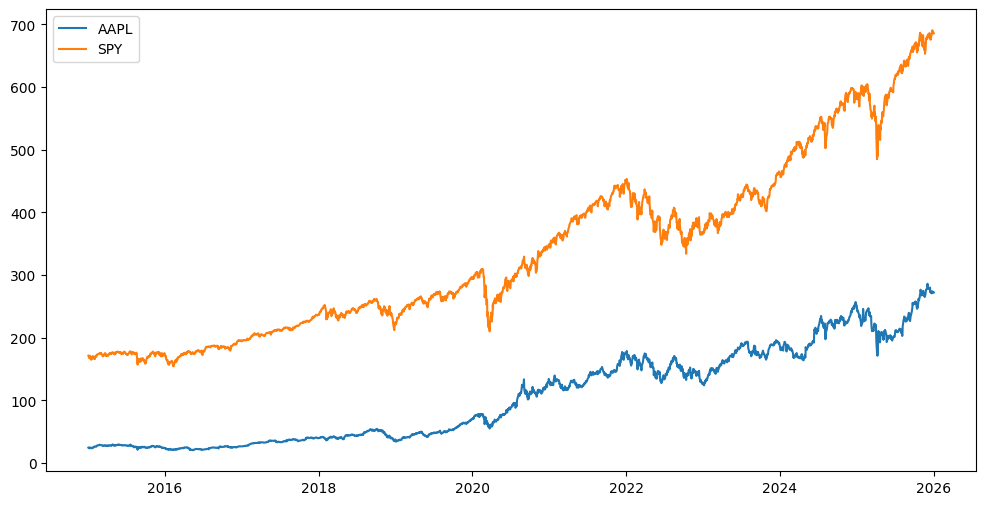

In [272]:
bt.plot()

In [273]:
window = 200
for stock in stocks:
    bt.data[("MA", stock)] = bt.data["Close", stock].rolling(window=200).mean()

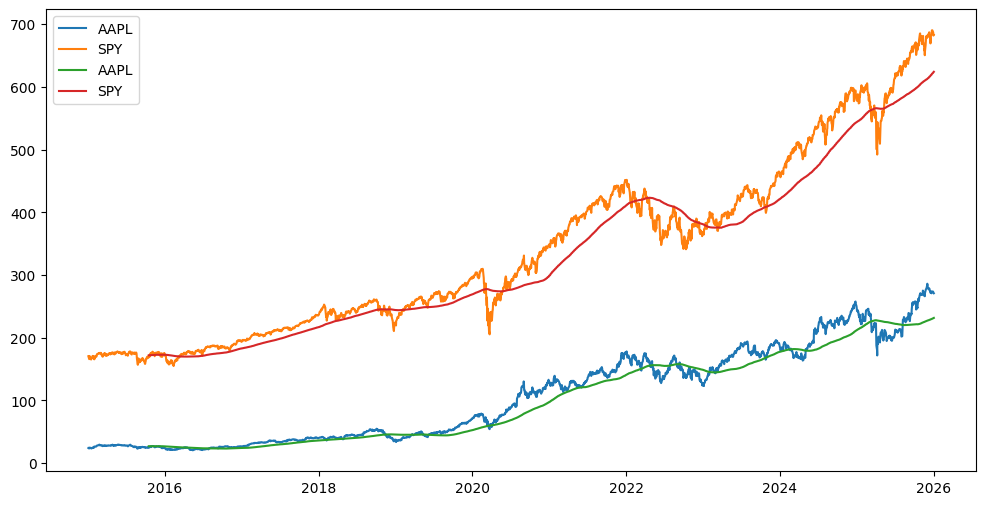

In [274]:
bt.plot(cols=["Close", "MA"])

In [275]:
class Strategy:
    def __init__(self, name, balance, backtest, stock=None):
        self.name = name
        self.balance = balance
        self.bt = backtest
        self.bt.add_strategy(self)
        self.stock = stock
    def _run(self):
        pass
    def _calculate_metrics(self):
        total_return = (bt.data[(self.name, "Balance")].iloc[-1] - bt.data[(self.name, "Balance")].iloc[0]) / bt.data[(self.name, "Balance")].iloc[0] * 100
        drawdown = (bt.data[(self.name, "Balance")].max() - bt.data[(self.name, "Balance")].min()) / bt.data[(self.name, "Balance")].max()
        return total_return, drawdown

In [276]:
class BuyHold(Strategy):
    def _run(self):
        super()._run()
        # first calculate the daily return of the stock, this is the daily return of our strategy
        self.bt.data[(self.name, "Daily_Ret")] = self.bt.data[("Close", self.stock)].pct_change(1)
        self.bt.data[(self.name, "Daily_Ret")].iloc[0] = 0
        # change strat balance buy daily ret
        self.bt.data[(self.name, "Balance")] = self.balance * (1 + self.bt.data[(self.name, "Daily_Ret")]).cumprod()

In [277]:
bh = BuyHold(name="Buy_Hold", balance=10000, backtest=bt, stock="SPY")

Total Return: 300.48%, Drawdown: 0.78%


/tmp/ipykernel_601/2272911742.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.bt.data[(self.name, "Daily_Ret")].iloc[0] = 0
/tmp/ipykernel_601/2272911742.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

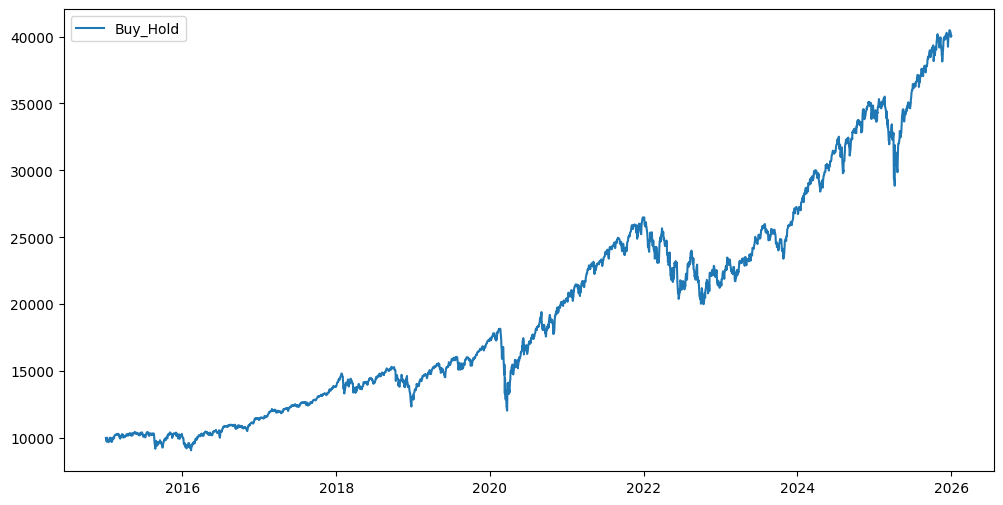

In [278]:
bt.run()